In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, Embedding, Reshape, Flatten, Dropout, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LayerNormalization, Add, Multiply,GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

In [2]:
df = pd.read_csv("Data_completa_enrriquecida.csv")  
df_audio_features = pd.read_csv("audio_features/audio_features_beat.csv")

In [3]:
def clean_song_id_lyrics(song_id):
    """Limpia y normaliza un songId de lyrics."""
    song_id = song_id.lower()  
    song_id = song_id.replace(".txt", "")  
    song_id = re.sub(r"[^a-z0-9-]", "", song_id) 
    song_id = song_id.replace(" ", "-")
    return song_id

def clean_song_id_audio(song_id):
    """Limpia y normaliza un songId de audio, conservando más información."""
    song_id = song_id.lower()
    song_id = re.sub(r"[^a-z0-9\s-]", "", song_id)  
    song_id = song_id.replace("feat ", "")  
    song_id = re.sub(r"\s+", " ", song_id).strip()  
    return song_id

In [4]:
df['songId'] = df['songId'].apply(clean_song_id_lyrics)
df_audio_features['song_id'] = df_audio_features['song_id'].apply(clean_song_id_audio)

In [5]:
# --- Alinear songIds  ---
song_ids_lyrics = set(df['songId'])
song_ids_audio = set(df_audio_features['song_id'])

In [6]:
song_ids_audio

{'21 seconds - dj swiss dan da man remix vocal - so solid crew',
 '240 - samad savage',
 'absolutist regeneration - deathspell omega',
 'act out - leroy george wilkes',
 'aint no way 6lack rico nasty jid jasiah kitty cah - denzel curry',
 'alices restaurant massacree - arlo guthrie',
 'angels hung from the arches of heaven - goatwhore',
 'arise again - soulfly',
 'bad bitchez - paul wall',
 'bamboo banga - dj eli remix - mia',
 'beno - playboi carti',
 'benz - samsonyte',
 'better dead than slave - violentor',
 'blunt after blunt - danny brown',
 'caesura - neaera',
 'casanova ssio - farid bang',
 'day in america - sun kil moon',
 'death in me produced by davenotti - braille',
 'death row - vybz kartel',
 'death trend setta - crossfade',
 'deliberate delusion - suicide',
 'dirty work - sweatshop union',
 'doctor online - zeromancer',
 'fear transmission - commentary - black veil brides',
 'feather in a baseball cap - architecture in helsinki',
 'fight the power - public enemy',
 'floor

In [7]:
song_ids_lyrics

{'expansion-creatures',
 'phantoms-in-sky-emptyself',
 'a-new-chance-tough-alliance',
 'say-youll-stay-in-my-arms-special-consensus',
 'ti-direi-velvet',
 'color-of-feels-kaito',
 'agony-in-her-body-sage-francis',
 'this-is-halloween-marilyn-manson',
 'beyond-stars-jimi-tenor',
 'sister-dont-cry-collective-soul',
 'your-song-kate-walsh',
 'how-do-i-live-without-you-mark-joseph',
 'hold-my-heart-part-one-letter-kills',
 'year-of-dog-lovely-sparrows',
 'a-sweet-little-bullet-from-a-pretty-blue-gun-tom-waits',
 'insects-party-scarlatti-tilt',
 'avalon-roxy-music',
 'fides-en-lucius-dei-immediate',
 'time-tesla',
 'chocolate-high-indiaarie',
 'merry-go-round-replacements',
 'dear-anne-sexton-vanessa-daou',
 'know-it-aint-right-mia',
 'born--raised-fake-problems',
 'creepy-crawling-chumbawamba',
 'butterflys-dream-erutan',
 'remember-christmas-harry-nilsson',
 'fire-song-company-of-thieves',
 'my-immortal-evanescence',
 'if-i-only-were-a-goth-thoushaltnot',
 'thank-you-louise-ryan-adams',
 

In [8]:
print("Número de songIds únicos en df:", df['songId'].nunique())
print("Número de songIds únicos en df_audio_features:", df_audio_features['song_id'].nunique())

Número de songIds únicos en df: 24026
Número de songIds únicos en df_audio_features: 87


In [9]:
# 2.  Verificar si hay songIds faltantes
missing_song_ids = song_ids_lyrics - song_ids_audio #Los que estan en lyrics y no en audio
initial_df_size = len(df)
if missing_song_ids:
    print(f"¡Faltan características de audio para estos songIds: {missing_song_ids}")

    # Crear un diccionario para mapeo aproximado:
    song_id_mapping = {}
    for lyric_id in missing_song_ids:
        best_match = None
        best_score = 0

        for audio_id in song_ids_audio:
            # Estrategia 1:  Ver si el ID de la letra está CONTENIDO en el ID del audio
            if lyric_id in audio_id:
              score = len(lyric_id) / len(audio_id)  # Puntuación basada en la longitud
              if score > best_score:
                  best_score = score
                  best_match = audio_id

            #Estrategia 2: Ver si el ID del audio esta CONTENIDO en el ID del lyric
            elif audio_id in lyric_id:
              score = len(audio_id) / len(lyric_id)
              if score > best_score:
                best_score = score
                best_match = audio_id

            #Estrategia 3: Comparar palabras
            else:
              lyric_words = set(lyric_id.split("-"))
              audio_words = set(audio_id.split()) #No separa por -, separa por espacios
              common_words = lyric_words.intersection(audio_words)
              score = len(common_words) / max(len(lyric_words), len(audio_words), 1) 
              if score > best_score:
                    best_score = score
                    best_match = audio_id

        if best_match:
            song_id_mapping[lyric_id] = best_match
            df.loc[df['songId'] == lyric_id, 'songId'] = best_match


¡Faltan características de audio para estos songIds: {'valores-do-passado-gesta', 'expansion-creatures', 'phantoms-in-sky-emptyself', 'erf-man-bites-god', 'no-me-arrependo-caetano-veloso', 'a-new-chance-tough-alliance', 'say-youll-stay-in-my-arms-special-consensus', 'ti-direi-velvet', 'wave-nancy-wilson', 'coffee-god-and-cigarettes-mischief-brew', 'color-of-feels-kaito', 'agony-in-her-body-sage-francis', 'thinking-out-loud-emilana-torrini', 'this-is-halloween-marilyn-manson', 'beyond-stars-jimi-tenor', 'love-tomorrow-maker', 'sister-dont-cry-collective-soul', 'your-song-kate-walsh', 'are-we-ready-wreck-two-door-cinema-club', 'how-do-i-live-without-you-mark-joseph', 'hold-my-heart-part-one-letter-kills', 'motte-groj', 'tiny-glass-houses-amelia-curran', 'goodbye-jane-siberry', 'year-of-dog-lovely-sparrows', 'a-sweet-little-bullet-from-a-pretty-blue-gun-tom-waits', 'insects-party-scarlatti-tilt', 'need-your-love-temper-trap', 'you-get-me-michelle-branch', 'all-over-world-tree63', 'knock-d

In [10]:
df.songId.values

array(['till-i-collapse-eminem', 'st anger - apocalyptica',
       'that way jeremih rick ross - wale', ...,
       'the marriage of attaris - draconian', 'last-inhale-tapage',
       'welcome to my hood - remix - dj khaled'], dtype=object)

In [11]:
df_audio_features.song_id.values

array(['240 - samad savage',
       '21 seconds - dj swiss dan da man remix vocal - so solid crew',
       'absolutist regeneration - deathspell omega',
       'act out - leroy george wilkes',
       'aint no way 6lack rico nasty jid jasiah kitty cah - denzel curry',
       'alices restaurant massacree - arlo guthrie',
       'angels hung from the arches of heaven - goatwhore',
       'arise again - soulfly', 'bad bitchez - paul wall',
       'bamboo banga - dj eli remix - mia', 'beno - playboi carti',
       'benz - samsonyte', 'better dead than slave - violentor',
       'blunt after blunt - danny brown', 'caesura - neaera',
       'casanova ssio - farid bang', 'day in america - sun kil moon',
       'death in me produced by davenotti - braille',
       'death row - vybz kartel', 'death trend setta - crossfade',
       'deliberate delusion - suicide', 'dirty work - sweatshop union',
       'doctor online - zeromancer',
       'fear transmission - commentary - black veil brides',
    

In [12]:
# Filtrar df para que solo tenga songIds presentes en df_audio_features
df = df[df['songId'].isin(song_ids_audio)]
df_audio_features = df_audio_features[df_audio_features['song_id'].isin(df['songId'])]

In [13]:

song_id_counts = df['songId'].value_counts()

duplicated_song_ids = song_id_counts[song_id_counts > 1].index

df[df['songId'].isin(duplicated_song_ids)].head(20)


,Letra,Idioma,lyrics_state,hasLetra,Lyrics,Lyrics_proces,songId,track_uri,track_name,artist_uri,...,dominance_tags,mbid,spotify_id,genre,cuadrante,cuadReal,lexicones,emociones,emocionesLetra,emocion_mas_comun
1,Data/Letras/2-St.-Anger-Metallica.txt,en,complete,1.0,St. Anger Lyrics[Verse]\nSaint Anger 'round my...,saint anger round neck saint anger round neck ...,st anger - apocalyptica,spotify:track:3fOc9x06lKJBhz435mInlH,St. Anger,spotify:artist:2ye2Wgw4gimLv2eAKyk1NB,...,5.427250,727a2529-7ee8-4860-aef6-7959884895cb,3fOc9x06lKJBhz435mInlH,metal,3,2,[0. 6. 0. 0. 0. 6. 0. 0. 0. 0.],"['anticipation', 'negative']","['3', '2']",3
2,Data/Letras/3-Speedin'-Rick-Ross.txt,en,complete,1.0,Speedin’ Lyrics[Intro: Rick Ross]\nLegendary\n...,legendary runners know trilla dollar count acc...,that way jeremih rick ross - wale,spotify:track:3Y96xd4Ce0J47dcalLrEC8,Speedin',spotify:artist:1sBkRIssrMs1AbVkOJbc7a,...,5.490000,NaN,3Y96xd4Ce0J47dcalLrEC8,rap,3,2,[0. 2. 0. 0. 0. 2. 0. 0. 0. 0.],"['anticipation', 'negative']","['3', '2']",3
3,Data/Letras/4-Bamboo-Banga-M.I.A..txt,en,complete,1.0,"Bamboo Banga Lyrics[Intro]\nRoad runner, road ...",road runner road runner going miles hour road ...,bamboo banga - dj eli remix - mia,spotify:track:6tqFC1DIOphJkCwrjVzPmg,Bamboo Banga,spotify:artist:0QJIPDAEDILuo8AIq3pMuU,...,5.691357,99dd2c8c-e7c1-413e-8ea4-4497a00ffa18,6tqFC1DIOphJkCwrjVzPmg,hip-hop,3,1,[0. 0. 0. 0. 0. 0. 4. 0. 0. 0.],['positive'],['1'],1
4,Data/Letras/5-Die-MF-Die-Dope.txt,en,complete,1.0,Die MF Die Lyrics[Intro]\nDie!\n\n[Verse 1]\nI...,die need forgiveness need hate need acceptance...,invaders must die - the prodigy,spotify:track:5bU4KX47KqtDKKaLM4QCzh,Die MF Die,spotify:artist:7fWgqc4HJi3pcHhK8hKg2p,...,5.441765,b9eb3484-5e0e-4690-ab5a-ca91937032a5,5bU4KX47KqtDKKaLM4QCzh,metal,3,1,[0. 1. 0. 0. 0. 1. 0. 0. 0. 0.],"['anticipation', 'negative']","['3', '2']",3
9,Data/Letras/10-Sweet-Amber-Metallica.txt,en,complete,1.0,Sweet Amber Lyrics[Verse 1]\nWash your back so...,wash stab bed kind live life drape shine wash ...,sweet amber - wasting days,spotify:track:5fU6qjmD38P90BMsuqpiuU,Sweet Amber,spotify:artist:2ye2Wgw4gimLv2eAKyk1NB,...,5.340000,fe1cc051-faa7-4953-b331-f6196cd3ddae,5fU6qjmD38P90BMsuqpiuU,metal,3,2,[0. 0. 0. 0. 0. 0. 2. 0. 0. 0.],['positive'],['1'],1
10,Data/Letras/11-Depression-Black-Flag.txt,en,complete,1.0,"Depression Lyrics[Verse]\nRight here, all by m...",right got situation bleeding relief person lik...,little black shoes - butch bastard,spotify:track:1qxkzHlZBXFv5HfyYqJ8cy,Depression,spotify:artist:5Mhs3Eu8lU6sRCtRYsmABV,...,4.422778,585398ed-1275-4579-9451-e8dd7db9d59c,1qxkzHlZBXFv5HfyYqJ8cy,punk,3,2,[0. 4. 0. 0. 0. 4. 0. 0. 0. 0.],"['anticipation', 'negative']","['3', '2']",3
11,Data/Letras/13-When-Girls-Telephone-Boys-Defto...,en,complete,1.0,When Girls Telephone Boys Lyrics[Intro: Spoken...,cops outside takes away kinda ill talk hella s...,when will they shoot - ice cube,spotify:track:6xK3sBdRm99g9T8Ov0gjdF,When Girls Telephone Boys,spotify:artist:6Ghvu1VvMGScGpOUJBAHNH,...,4.631852,3bc2c1a9-43bc-45b2-87fc-4313eb2534fe,6xK3sBdRm99g9T8Ov0gjdF,metal,3,2,[0. 1. 0. 0. 0. 1. 0. 0. 0. 0.],"['anticipation', 'negative']","['3', '2']",3
13,Data/Letras/16-Requiem-Lamb-of-God.txt,en,complete,1.0,"Requiem Lyrics[Verse 1]\nDown, chemical sacram...",chemical sacrament blasphemous prayer deliver ...,messiah hwv 56 part ii chorus behold the lamb ...,spotify:track:0DxYrFOfiFShTbO2XdFpBX,Requiem,spotify:artist:3JFsVIxOn7STeilPICkkB2,...,5.214000,23b46286-3b27-431b-8943-9be9d37836f9,0DxYrFOfiFShTbO2XdFpBX,metalcore,3,2,[0. 3. 0. 0. 0. 3. 0. 0. 0. 0.],"['anticipation', 'negative']","['3', '2']",3
14,Data/Letras/17-Room-13-Black-Flag.txt,en,complete,1.0,Room 13 LyricsKeep me alive\nOnly you can do i...,alive die ill hard survive know alive accept f...,floor 13 - mgk,spotify:track:7EZlzu01NzbR1jWEIDSk5T,Room 13,spotify:artist:5Mhs3Eu8lU6sRCtRYsmABV,...,4.716296,b83fe0b7-d40d-4e77-9b2b-606d36e4a391,7EZlzu01NzbR1jWEIDSk5T,punk,3,2,[0. 0. 

In [14]:
# Función para manejar duplicados de songId
def consolidate_group(group):
    return pd.Series({
        'Idioma': group['Idioma'].mode()[0],  # Valor más frecuente
        'lyrics_state': group['lyrics_state'].mode()[0],  # Valor más frecuente
        'hasLetra': group['hasLetra'].max(),  # Mantiene el 1 si hay
        'Lyrics': max(group['Lyrics'], key=len),  # Lyrics más largo
        'Lyrics_proces': max(group['Lyrics_proces'], key=len),  # Procesado más largo
        'track_uri': group['track_uri'].mode()[0],  # Track más frecuente
        'emocion_mas_comun': group['emocion_mas_comun'].mode()[0],  # Emoción más frecuente
        'cuadrante': group['cuadrante'].mode()[0],  #  más frecuente
        'cuadReal': group['cuadReal'].mode()[0]  #  más frecuente
    })


df = df.groupby('songId').apply(consolidate_group).reset_index()
print("Número de songIds únicos después de consolidar:", df['songId'].nunique())

Número de songIds únicos después de consolidar: 85


C:\Users\andre\AppData\Local\Temp\ipykernel_23352\2007343470.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('songId').apply(consolidate_group).reset_index()


In [15]:
df.shape

(85, 10)

In [16]:
df.cuadReal.unique()

array([1, 2, 3, 4], dtype=int64)

In [17]:
df = df.rename(columns={'songId': 'song_id'})

df_merged = df.merge(df_audio_features, on='song_id', how='inner')

print("IDs únicos tras merge:", df_merged['song_id'].nunique()) 
print("Filas en df_merged:", len(df_merged))

IDs únicos tras merge: 85
Filas en df_merged: 85


In [18]:
df_merged.shape

(85, 11)

In [19]:
df_merged

,song_id,Idioma,lyrics_state,hasLetra,Lyrics,Lyrics_proces,track_uri,emocion_mas_comun,cuadrante,cuadReal,beat_features
0,21 seconds - dj swiss dan da man remix vocal -...,en,complete,1.0,7 ContributorsAngela’s Ashes LyricsAngela's As...,angelas ashes memoir childhood frank mccourt b...,spotify:track:0N9LQXtUL7TLtIoa7gpJfX,3,0,1,"[[0.6232354044914246, 0.7310153841972351, 0.68..."
1,240 - samad savage,en,complete,1.0,18 ContributorsI Knew I Loved You Lyrics[Intro...,cool cruel sleaze hungry wild crawling storm b...,spotify:track:0GYXt2CnvXNXA1Bv6n493A,3,0,1,"[[0.1179114505648613, 0.11783639341592789, 0.2..."
2,absolutist regeneration - deathspell omega,en,complete,1.0,The Repellent Scars of Abandon and Election Ly...,feeling destroying capacity inward peace insan...,spotify:track:5F16S6W1HPzyi5vGzwVJyM,2,1,2,"[[0.6578890085220337, 0.5009267330169678, 0.56..."
3,act out - leroy george wilkes,en,complete,1.0,36 ContributorsUlysses (Chap. 15 - Circe) Lyri...,mabbot street entrance nighttown stretches unc...,spotify:track:04wGcU52bFtUoAC7WBKgF3,3,0,3,"[[0.19272536039352417, 0.16313757002353668, 0...."
4,aint no way 6lack rico nasty jid jasiah kitty ...,en,complete,1.0,5 ContributorsNames of People (Chapter 1) Lyri...,chapter names people duchesse guermantes saint...,spotify:track:0jngaR7DQWMye5yYn7fzqd,3,0,1,"[[0.2387864887714386, 0.08314859867095947, 0.1..."
...,...,...,...,...,...,...,...,...,...,...,...
80,welcome to my hood - remix - dj khaled,en,complete,1.0,5 ContributorsNames of People (Chapter 1) Lyri...,chapter names people duchesse guermantes saint...,spotify:track:0Z1aLPrrjQsvVgo0H4X2BN,3,0,2,"[[0.176896333694458, 0.16770079731941223, 0.23..."
81,when will they shoot - ice cube,en,complete,1.0,Madame Swann at Home (Chapter 1) Lyrics ...,tale king omar bin alnuuman sons sharrkan zau ...,spotify:track:2kVSOg4uN0TNQ18L0NxUJ1,3,0,1,"[[0.3816147744655609, 0.7537561655044556, 1.0,..."
82,why do little girls - harry chapin,en,complete,1.0,Essays of Michel de Montaigne (Chap. 2.12) Lyr...,apology raimond sebond learning great material...,spotify:track:3fIYMofKZa1kDymEZZumAW,3,0,1,"[[0.1473957896232605, 0.11003975570201874, 0.0..."
83,wollt ihr das bett in flammen sehen - rammstein,de,complete,1.0,1 ContributorKaspar Hauser - Augenzeugenberich...,mitteilungen ber kaspar hauser von georg daume...,spotify:track:1F4bbhaNSWNYVZyXsRgGWW,2,2,3,"[[0.03964819759130478, 0.04151257872581482, 0...."


In [20]:
print(f"Number of rows in df: {len(df_merged)}")
print(f"Number of rows in df_audio_features: {len(df_audio_features)}")

Number of rows in df: 85
Number of rows in df_audio_features: 85


In [21]:
print(f"Number of rows in df (AFTER filtering): {len(df)}") 
print(f"Number of rows in df_audio_features (AFTER filtering): {len(df_audio_features)}")  
print("Unique song IDs in df:", df_merged['song_id'].nunique())  
print("Unique song IDs in df_audio_features:", df_audio_features['song_id'].nunique())  

Number of rows in df (AFTER filtering): 85
Number of rows in df_audio_features (AFTER filtering): 85
Unique song IDs in df: 85
Unique song IDs in df_audio_features: 85


In [22]:
# --- Preparar beat_features ---
df_merged['beat_features'] = df_merged['beat_features'].apply(eval)
df_merged['beat_features'] = df_merged['beat_features'].apply(np.array)
max_len = max(df_merged['beat_features'].apply(len))
padded_beat_features = pad_sequences(df_merged['beat_features'], maxlen=max_len, dtype='float32', padding='post')
print(f"Shape de padded_beat_features: {padded_beat_features.shape}")

Shape de padded_beat_features: (85, 3016, 38)


In [23]:
audio_features_array = padded_beat_features

In [24]:
audio_features_array.shape

(85, 3016, 38)

In [25]:
num_songs = padded_beat_features.shape[0]
num_features = padded_beat_features.shape[2]
flattened_audio_features = padded_beat_features.reshape(num_songs, -1)

In [26]:
scaler_audio = StandardScaler()
scaled_audio_features = scaler_audio.fit_transform(flattened_audio_features)

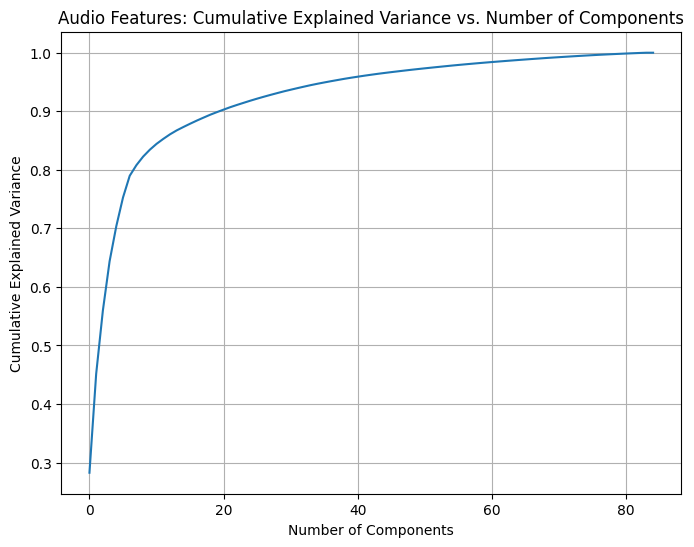

In [27]:
pca_audio_full = PCA()
pca_audio_full.fit(scaled_audio_features)

explained_variance_ratio_audio = np.cumsum(pca_audio_full.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(explained_variance_ratio_audio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Audio Features: Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [28]:
pca_audio = PCA(n_components=60)
pca_audio_features = pca_audio.fit_transform(scaled_audio_features)
print(f"Number of audio components after PCA: {pca_audio.n_components_}")

Number of audio components after PCA: 60


In [29]:
audio_features_array = pca_audio_features.reshape(num_songs, -1, pca_audio.n_components_) 

In [30]:
df_merged = df_merged[['Idioma', 'lyrics_state', 'hasLetra', 'Lyrics', 'Lyrics_proces',
         'song_id', 'track_uri', 'emocion_mas_comun', 'cuadrante',
         'cuadReal','beat_features']]

In [31]:
import os
tfidf_filename = "vect.joblib"  

if os.path.exists(tfidf_filename):
    # Load the PRE-TRAINED vectorizer
    print(f"Loading pre-trained TfidfVectorizer from {tfidf_filename}...")
    vect = joblib.load(tfidf_filename)
    tfidf_matrix = vect.transform(df['Lyrics_proces']) 
    print("Vectorizer loaded and text transformed.")
else:
    # Train and save a NEW vectorizer
    print("Training a new TfidfVectorizer...")
    corpus = df_merged['Lyrics_proces']
    vect = TfidfVectorizer(sublinear_tf=True, min_df=50, max_df=0.6)  
    tfidf_matrix = vect.fit_transform(corpus)  # Use fit_transform() for training
    joblib.dump(vect, tfidf_filename)  
    print(f"Vectorizer trained and saved as {tfidf_filename}")

Training a new TfidfVectorizer...
Vectorizer trained and saved as vect.joblib


In [32]:
scaler_text = StandardScaler(with_mean=False) #with_mean = False, since the data is sparse
tfidf_matrix_scaled = scaler_text.fit_transform(tfidf_matrix)

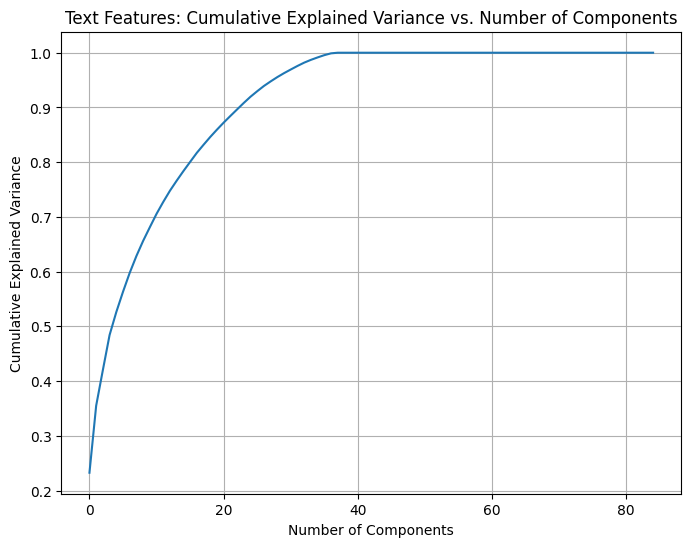

In [33]:
pca_text_full = PCA()
pca_text_full.fit(tfidf_matrix_scaled.toarray())  

explained_variance_ratio_text = np.cumsum(pca_text_full.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(explained_variance_ratio_text)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Text Features: Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [34]:
pca_text = PCA(n_components=40)
pca_text_features = pca_text.fit_transform(tfidf_matrix_scaled.toarray())
print(f"Number of text components after PCA: {pca_text.n_components_}")

Number of text components after PCA: 40


In [35]:
df.head(2)

,song_id,Idioma,lyrics_state,hasLetra,Lyrics,Lyrics_proces,track_uri,emocion_mas_comun,cuadrante,cuadReal
0,21 seconds - dj swiss dan da man remix vocal -...,en,complete,1.0,7 ContributorsAngela’s Ashes LyricsAngela's As...,angelas ashes memoir childhood frank mccourt b...,spotify:track:0N9LQXtUL7TLtIoa7gpJfX,3,0,1
1,240 - samad savage,en,complete,1.0,18 ContributorsI Knew I Loved You Lyrics[Intro...,cool cruel sleaze hungry wild crawling storm b...,spotify:track:0GYXt2CnvXNXA1Bv6n493A,3,0,1


In [36]:
df_audio_features.head(2)

,song_id,beat_features
0,240 - samad savage,"[[0.1179114505648613, 0.11783639341592789, 0.2..."
1,21 seconds - dj swiss dan da man remix vocal -...,"[[0.6232354044914246, 0.7310153841972351, 0.68..."


In [37]:
df_merged.head(2)

,Idioma,lyrics_state,hasLetra,Lyrics,Lyrics_proces,song_id,track_uri,emocion_mas_comun,cuadrante,cuadReal,beat_features
0,en,complete,1.0,7 ContributorsAngela’s Ashes LyricsAngela's As...,angelas ashes memoir childhood frank mccourt b...,21 seconds - dj swiss dan da man remix vocal -...,spotify:track:0N9LQXtUL7TLtIoa7gpJfX,3,0,1,"[[0.6232354044914246, 0.7310153841972351, 0.68..."
1,en,complete,1.0,18 ContributorsI Knew I Loved You Lyrics[Intro...,cool cruel sleaze hungry wild crawling storm b...,240 - samad savage,spotify:track:0GYXt2CnvXNXA1Bv6n493A,3,0,1,"[[0.1179114505648613, 0.11783639341592789, 0.2..."


In [38]:
X_audio = audio_features_array 
X_text = pca_text_features 


y = df_merged['cuadReal'].values 
y = tf.keras.utils.to_categorical(y, num_classes=5) 
y = y[:, 1:] # Remove the 0 index class

In [39]:
print(f"X_audio shape: {X_audio.shape}")  
print(f"X_text shape: {X_text.shape}")  
print(f"y shape: {y.shape}")      #

X_audio shape: (85, 1, 60)
X_text shape: (85, 40)
y shape: (85, 4)


In [40]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],


In [41]:
# --- Model 1: Bidirectional LSTM + Dropout + Deeper Text Network ---
def create_model_1(max_len_beats, num_audio_features, num_text_features, num_classes):
    input_audio = Input(shape=(max_len_beats, num_audio_features), name='audio_input')
    input_text = Input(shape=(num_text_features,), name='text_input')

    # Audio Processing
    lstm_audio = Bidirectional(LSTM(256, return_sequences=True))(input_audio)  
    lstm_audio = Dropout(0.3)(lstm_audio)  

    # Text Processing
    dense_text = Dense(512, activation='relu')(input_text)  
    dense_text = Dropout(0.3)(dense_text)
    dense_text = Dense(256, activation='relu')(dense_text) 
    dense_text = Dropout(0.3)(dense_text)
    expanded_text = Reshape((1, 256))(dense_text)
    repeated_text = tf.repeat(expanded_text, repeats=max_len_beats, axis=1)

    # Attention
    attention_layer = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=256)
    attention_output, attention_scores = attention_layer(query=repeated_text, value=lstm_audio, return_attention_scores=True)
    
    # Fusion
    merged = Concatenate(axis=-1)([attention_output, repeated_text])
    merged = Flatten()(merged)
    merged = Dense(512, activation='relu')(merged)  
    merged = Dropout(0.3)(merged)

    # Output
    output = Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=[input_audio, input_text], outputs=output)
    return model

In [42]:
def create_model_transformer_audio(max_len_beats, num_audio_features, num_text_features, num_classes):
    input_audio = Input(shape=(max_len_beats, num_audio_features), name='audio_input')
    input_text = Input(shape=(num_text_features,), name='text_input')

    # Procesamiento de audio con Transformer
    x_audio = Dense(128, activation='relu')(input_audio)
    # Nota: Asegúrate de definir o importar un bloque de Transformer, ya que Keras tiene variantes en su API.
    transformer_block = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=32)
    audio_attention = transformer_block(query=x_audio, value=x_audio, key=x_audio)
    audio_features = GlobalAveragePooling1D()(audio_attention)

    # Procesamiento del texto
    text_features = Dense(256, activation='relu')(input_text)
    text_features = Dropout(0.3)(text_features)

    # Fusión de características
    fused = Concatenate()([audio_features, text_features])
    fused = Dense(256, activation='relu')(fused)
    fused = Dropout(0.3)(fused)
    
    output = Dense(num_classes, activation='softmax')(fused)
    model = Model(inputs=[input_audio, input_text], outputs=output)
    return model


In [43]:
num_audio_features = X_audio.shape[2]
max_len_beats = X_audio.shape[1]
num_text_features = X_text.shape[1]
num_classes = y.shape[1]
model = create_model_1(max_len_beats, num_audio_features, num_text_features, num_classes)  
#model = create_model_2(max_len_beats, num_audio_features, num_text_features, num_classes)
#model = create_model_3(max_len_beats, num_audio_features, num_text_features, num_classes)
#model = create_model_4(max_len_beats, num_audio_features, num_text_features, num_classes)  
#model = create_model_cross_attention(max_len_beats, num_audio_features, num_text_features, num_classes) 


In [44]:
optimizer = Adam(learning_rate=1e-4) 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 40)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          20992       ['text_input[0][0]']             
                                                                                                  
 dropout_1 (Dropout)            (None, 512)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 256)          131328      ['dropout_1[0][0]']              
                                                                                              

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=1e-6)


In [47]:
# --- Training ---
history = model.fit(
    [X_audio, X_text],
    y,
    epochs=100,  
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping] )

Epoch 1/100
3/3 [==============================] - 7s 552ms/step - loss: 1.4745 - accuracy: 0.3235 - val_loss: 1.3476 - val_accuracy: 0.5294
Epoch 2/100
3/3 [==============================] - 0s 89ms/step - loss: 1.2680 - accuracy: 0.4559 - val_loss: 1.2877 - val_accuracy: 0.4706
Epoch 3/100
3/3 [==============================] - 0s 50ms/step - loss: 1.3181 - accuracy: 0.3824 - val_loss: 1.2472 - val_accuracy: 0.4118
Epoch 4/100
3/3 [==============================] - 0s 70ms/step - loss: 1.1127 - accuracy: 0.5147 - val_loss: 1.2181 - val_accuracy: 0.4118
Epoch 5/100
3/3 [==============================] - 0s 69ms/step - loss: 1.1401 - accuracy: 0.4706 - val_loss: 1.1928 - val_accuracy: 0.3529
Epoch 6/100
3/3 [==============================] - 0s 73ms/step - loss: 0.9996 - accuracy: 0.6324 - val_loss: 1.1725 - val_accuracy: 0.3529
Epoch 7/100
3/3 [==============================] - 0s 48ms/step - loss: 0.9758 - accuracy: 0.5882 - val_loss: 1.1550 - val_accuracy: 0.3529
Epoch 8/100
3/3 [==

In [48]:
# --- Evaluate ---
loss, accuracy = model.evaluate([X_audio, X_text], y, verbose=0)
print(f"Final Loss: {loss:.4f}")
print(f"Final Accuracy: {accuracy:.4f}")

Final Loss: 0.3177
Final Accuracy: 0.8588


In [49]:
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

Final Validation Loss: 1.2769
Final Validation Accuracy: 0.4706


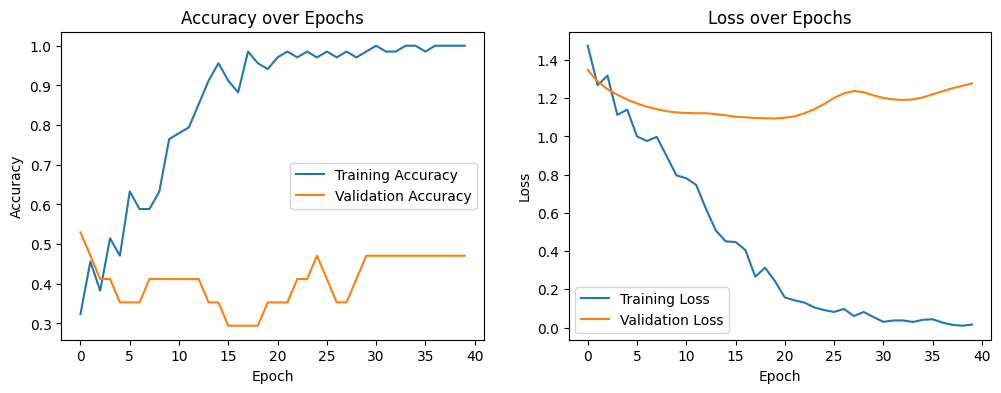

In [50]:
# --- Plot Training History ---

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()
